# Read the files

In [1]:
library("tidyverse")
library("janitor")
library("caret")
library("mlr")
library("parallelMap")
library("ggthemr")

ggthemr("fresh")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Loading required package: ParamHelpers

Attaching package: ‘mlr’

The following object is masked from ‘package:caret’:

    train

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

In [2]:
parallelStartSocket(cpus = 39)
#parallelStartMulticore(cpus = 39)

Starting parallelization in mode=socket with cpus=39.


In [3]:
df_train = readRDS("df_train_after_03FE.RData")
df_val = readRDS("df_val_after_03FE.RData")
cols_with_low_iv_values = readRDS("cols_with_low_iv_values.RData")
cols_with_woe_added = readRDS("cols_with_woe_added.RData")

In [4]:
cols_with_low_iv_values %>% cat(sep = " \n ")

nbrhud_comm_180d_violation_cnt 
 zone_type 
 mos_species 
 ses_lt_hs_pct_tract2017 
 loc_lat_lng_src 
 nbrhud_blk_grp_180d_violation_cnt 
 nbrhud_zipcode_180d_violation_cnt 
 t_day_of_yr 
 trap_trap_type 
 mos_salinarius_num_mosquitos 
 mos_unspecified_num_mosquitos 
 mos_erraticus_num_mosquitos 
 mos_tarsalis_num_mosquitos 
 trap_satellite_ind 
 t_day 
 mos_territans_num_mosquitos 
 nbrhud_comm_180d_vacancies_cnt 
 wea_ohare_tavg2_ma7 
 nbrhud_blk_grp_180d_vacancies_cnt 
 nbrhud_zipcode_180d_vacancies_cnt 
 wea_ohare_prcp 
 googtrend_deadbirds 
 wea_ohare_prcp_sum7 
 mos_restuans_num_mosquitos 
 wea_ohare_tavg2_ma60_lag21 
 wea_ohare_tmax 
 wea_ohare_prcp_sum60_lag7


# Little cleanup

In [5]:
# Remove cols_with_low_iv_values to make life a bit simplier

#df_train = df_train %>% select(-cols_with_low_iv_values)
#df_val = df_val %>% select(-cols_with_low_iv_values)

In [6]:
df_train = df_train %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected"))) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name)
df_val = df_val %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected"))) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name)

In [7]:
stopifnot(df_train %>% select_if(is.factor) %>% map_int(~length(levels(.x))) == 
              df_val %>% select_if(is.factor) %>% map_int(~length(levels(.x))))

### Remove NA rows from val set

In [8]:
df_val = df_val[complete.cases(df_val),]

### Make y the 1st col

In [9]:
make_resp_first_var = function(df){
    pred_cols = names(df %>% select(-y))
    df %>% select(y, pred_cols)
}

In [10]:
df_train = df_train %>% make_resp_first_var
df_val   = df_val   %>% make_resp_first_var

In [11]:
dim(df_train)

[1] 15257    64

In [12]:
dim(df_val)

[1] 5903   64

In [13]:
predictors = df_train %>% select(-y) %>% names

Number of levels of all factor vars:

In [14]:
df_train %>% select_if(is.factor) %>% map_int(~length(levels(.x)))

y             t_mo            t_qtr t_day_of_wk_name 
               2                6                3                5 
 loc_lat_lng_src      loc_zipcode       zone_class        zone_type 
               2               47               38                7 
  trap_trap_type      mos_species 
               4                8

## Putting train & val data together

Since `mlr` can handle these data together (much easier) using either holdout, or 5-fold CV, I'm putting these two sets together again.

In [15]:
df_model = df_train %>% bind_rows(df_val)

In [16]:
dim(df_model)

[1] 21160    64

In [17]:
cat("Holdout % : ", round(nrow(df_train)/nrow(df_model),3))

Holdout % :  0.721

# Model Setup

## Preprocess Data

In [18]:
wnv = createDummyFeatures(df_model,target = "y")
wnv = removeConstantFeatures(wnv)

Removing 2 columns: zone_class.PMD.2,trap_trap_type.SENTINEL


## Create Classification Task & Split

In [19]:
tsk = makeClassifTask(data = wnv, target = "y", positive = "Infected")
tsk

Supervised task: wnv
Type: classif
Target: y
Observations: 21160
Features:
   numerics     factors     ordered functionals 
        172           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
   Clean Infected 
   18175     2985 
Positive class: Infected

# Feature Importance

In [20]:
fv = generateFilterValuesData(tsk, method = "anova.test")
fv

FilterValues:
Task: wnv
         name    type anova.test
1       t_day integer   5.763191
2        t_wk integer 336.653767
3 t_day_of_yr integer 371.103321
4 t_day_of_wk integer  69.448454
5  t_eval_day integer 521.900156
6   t_eval_wk integer 521.824912
... (#rows: 172, #cols: 3)

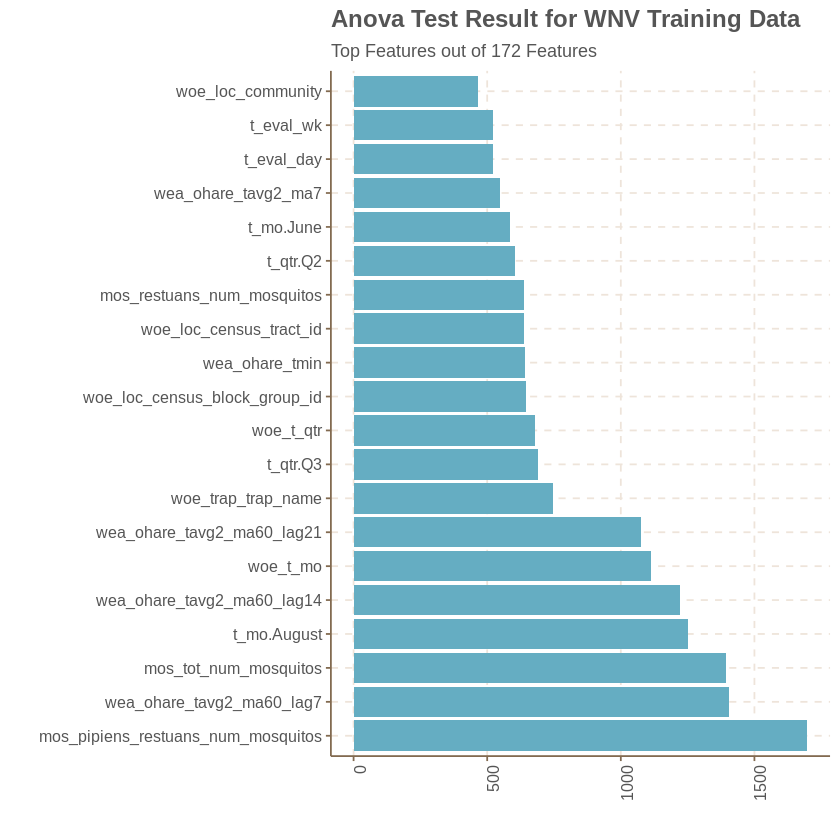

In [21]:
plotFilterValues(fv) + 
    labs(title="Anova Test Result for WNV Training Data", subtitle="Top Features out of 172 Features") + 
    theme(axis.text.x = element_text(angle = 90)) + 
    coord_flip()

fv = generateFilterValuesData(tsk, method = c("randomForest.importance"))
fv

plotFilterValues(fv,facet.wrap.nrow = 2) + 
    labs(title="Random Forest Importance Plot", subtitle="Top Features out of 172 Features") + 
    theme(axis.text.x = element_text(angle = 90)) + 
    coord_flip()

## Build the model

In [22]:
rdesc = makeResampleDesc("Holdout", stratify = TRUE, split = 0.721)

In [42]:
lrns = list(makeLearner(id = "rpart", cl = "classif.rpart", predict.type = "prob"),
            makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob"),
            makeLearner(id = "xgb", cl = "classif.xgboost", predict.type = "prob", nthread=25),
            makeLearner(id = "adaboost", cl = "classif.adaboostm1", predict.type = "prob"),
            makeLearner(id = "cforest", cl = "classif.cforest", predict.type = "prob"),
            makeLearner(id = "C50", cl = "classif.C50", predict.type = "prob"),
            makeLearner(id = "gbm", cl = "classif.gbm", predict.type = "prob"),
            makeLearner(id = "dbnDNN", cl = "classif.dbnDNN", predict.type = "prob"),
            makeLearner(id = "svm", cl = "classif.svm", predict.type = "prob"),
            makeLearner(id = "svm_radial", cl = "classif.svm", predict.type = "prob", kernel = "radial"),
            makeLearner(id = "extraTrees", cl = "classif.extraTrees", predict.type = "prob", numThreads = 25))

#makePreprocWrapperCaret(makeLearner(id = "eTrees_norm","classif.evtree",predict.type = "prob"), ppc.center = TRUE, ppc.scale = TRUE)

In [43]:
meas = list(auc, mmce, f1, tpr, fpr, fnr, timetrain)

In [44]:
bmr = benchmark(learners = lrns, tasks = tsk, resamplings = rdesc, measures = meas, show.info = TRUE)

Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 11.


In [45]:
bmr

   task.id learner.id auc.test.mean mmce.test.mean f1.test.mean tpr.test.mean
1      wnv      rpart     0.7816962     0.10721545    0.5043070     0.3865546
2      wnv         rf     0.9816441     0.02726965    0.8961960     0.8343337
3      wnv        xgb     0.8963596     0.10044038    0.5668371     0.4657863
4      wnv   adaboost     0.8756317     0.11500678    0.4211424     0.2965186
5      wnv    cforest     0.9341287     0.10924797    0.3909348     0.2484994
6      wnv        C50     0.9078098     0.07859079    0.6890080     0.6170468
7      wnv        gbm     0.7784532     0.14109079    0.0000000     0.0000000
8      wnv     dbnDNN     0.5000000     0.14109079    0.0000000     0.0000000
9      wnv        svm     0.9647349     0.03743225    0.8507765     0.7563025
10     wnv svm_radial     0.9646048     0.03726287    0.8517520     0.7587035
11     wnv extraTrees     0.9859502     0.02625339    0.9014622     0.8511405
   fpr.test.mean fnr.test.mean timetrain.test.mean
1    0.024058

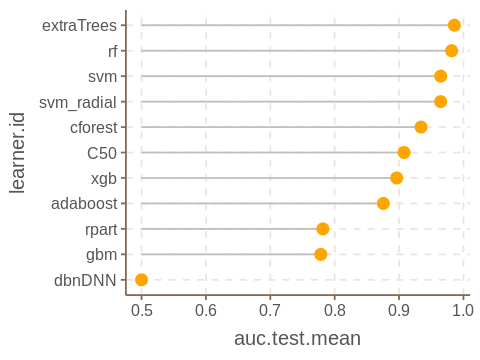

In [95]:
options(repr.plot.width=4, repr.plot.height=3)
getBMRAggrPerformances(bmr, as.df = T) %>%
    mutate(learner.id = forcats::fct_reorder(learner.id,auc.test.mean,.desc = F)) %>%
    ggplot(aes(learner.id, auc.test.mean))+
    geom_segment(aes(xend=learner.id,yend=0.5),color="gray")+
    geom_point(size=3,color="orange")+
    coord_flip()

In [96]:
df = generateThreshVsPerfData(bmr, measures = list(fpr, tpr, mmce))

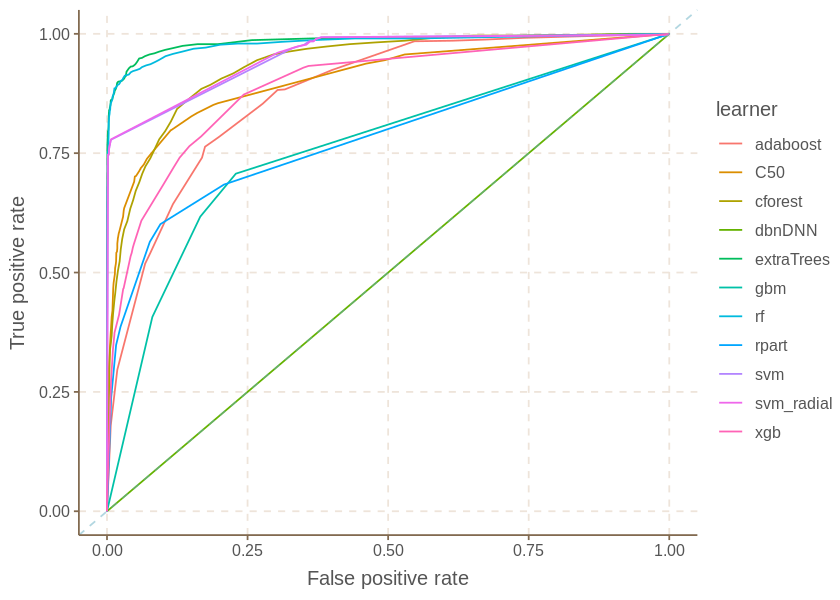

In [97]:
options(repr.plot.width=7, repr.plot.height=5)
plotROCCurves(df)

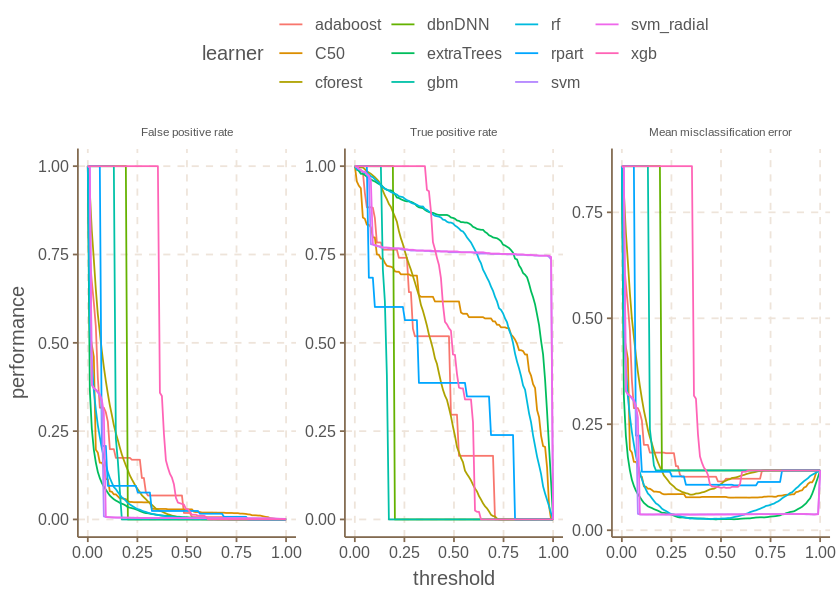

In [98]:
plotThreshVsPerf(df) +
  theme(strip.text.x = element_text(size = 7), legend.position = "top")

In [100]:
saveRDS(object = bmr, file = "bmr_001.RData")

In [101]:
getwd()

[1] "/home/rahul/Documents/Capstone/git/src/rahul"